In [ ]:
!pip install dython

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import ADASYN
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

from scipy.stats import shapiro, skew, kurtosis
from dython.nominal import associations


import warnings
warnings.filterwarnings("ignore", category=FutureWarning)



In [ ]:
file_path = '/content/drive/MyDrive/data-science-project/ad_click_dataset.csv'
df = pd.read_csv(file_path)


• `file_path` değişkenine veri yolumuzu atadık.

• dosyamız csv dosyası olduğundan, `pd.read_csv` fonksiyonu ile verilerimizi okuduk.

• `df` değişkenine aktardık, artık verilerimiz `df` değişkeninde saklanıyor.

In [ ]:
df.head()

,id,full_name,age,gender,device_type,ad_position,browsing_history,time_of_day,click
0,670,User670,22.0,NaN,Desktop,Top,Shopping,Afternoon,1
1,3044,User3044,NaN,Male,Desktop,Top,NaN,NaN,1
2,5912,User5912,41.0,Non-Binary,NaN,Side,Education,Night,1
3,5418,User5418,34.0,Male,NaN,NaN,Entertainment,Evening,1
4,9452,User9452,39.0,Non-Binary,NaN,NaN,Social Media,Morning,0


In [ ]:
df.tail()

,id,full_name,age,gender,device_type,ad_position,browsing_history,time_of_day,click
9995,8510,User8510,NaN,NaN,Mobile,Top,Education,NaN,0
9996,7843,User7843,NaN,Female,Desktop,Bottom,Entertainment,NaN,0
9997,3914,User3914,NaN,Male,Mobile,Side,NaN,Morning,0
9998,7924,User7924,NaN,NaN,Desktop,NaN,Shopping,Morning,1
9999,3056,User3056,44.0,Male,Tablet,Top,Social Media,Morning,0


`df.head()` ile verilerimizin ilk 5 satırını, `df.tail()` ile son 5 satırını görüntülüyor ve genel bir bakış elde ediyoruz.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                10000 non-null  int64  
 1   full_name         10000 non-null  object 
 2   age               5234 non-null   float64
 3   gender            5307 non-null   object 
 4   device_type       8000 non-null   object 
 5   ad_position       8000 non-null   object 
 6   browsing_history  5218 non-null   object 
 7   time_of_day       8000 non-null   object 
 8   click             10000 non-null  int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 703.2+ KB



• df.info() ile verilerimiz hakkında genel bilgiler edindik.

• toplamda 10.000 tane veri var.

• 3 tane sütunda NULL veri olmadığını görüyoruz.

• verisetimiz 9 tane sütundan oluşuyor.

• sütunlardaki verilerin veri tipleri ise şu şekilde: float64 1 sütun, int64 2 sütun, object 6 sütun.

In [ ]:
df = df.drop(columns=['id'])


'id' sütunu bizim analizimiz için bir anlam ifade etmediğinden bu sütunu kaldırmayı tercih ettik.


In [ ]:
df.describe(include='all')

,full_name,age,gender,device_type,ad_position,browsing_history,time_of_day,click
count,10000,5234.000000,5307,8000,8000,5218,8000,10000.000000
unique,4000,NaN,3,3,3,5,4,NaN
top,User1171,NaN,Female,Desktop,Bottom,Entertainment,Morning,NaN
freq,25,NaN,1834,2754,2817,1175,2126,NaN
mean,NaN,40.197363,NaN,NaN,NaN,NaN,NaN,0.650000
std,NaN,13.126420,NaN,NaN,NaN,NaN,NaN,0.476993
min,NaN,18.000000,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,29.000000,NaN,NaN,NaN,NaN,NaN,0.000000
50%,NaN,39.500000,NaN,NaN,NaN,NaN,NaN,1.000000
75%,NaN,52.000000,NaN,NaN,NaN,NaN,NaN,1.000000



describe fonksiyonu ile genel istatistik bilgiler elde ediyoruz. include='all' parametresini vermemizin sebebi ise, sadece sayısal değil bütün sütunlar hakkında bilgi edinmek istememiz.




> full_name sütunun metriklerine baktığımızda;

▪︎ 4000 tane eşsiz kullanıcı adı yani kullanıcı olduğunu görüyoruz.

▪︎ top değerinde 'User1171' var, yani verisetimize en çok 'User1171' kullanıcısının davranışı girilmiş.bu doğrultuda, bir kullanıcı için birden fazla davranış verisinin olduğunu söyleyebiliriz, freq değerine baktığımızda ise bu kullanıcı için 25 tane veri bulunuyor.

▪︎  toplamda 10000 veri görünüyor, fakat 4000 tane unique veri var. 6000 tane veri, 4000 eşsiz kullanıcıların farklı verilerini içeriyor.


> age sütunu için;

▪︎  mean değeri: 40.197363. yani yaş ortalaması yaklaşık 40.

▪︎  min değerine baktığımızda ise verisi eklenen en küçük yaştaki kullanıcının 18 yaşında olduğunu görüyoruz.

▪︎  max değeri ise 64, en büyük yaştaki kullanıcı 64 yaşında.

> gender sütunu için;

▪︎  unique değeri: 3. yani kadın, erkek ve non-binary bilgisi girilmiş. (head fonksiyonunun çıktısına baktığımızda net bir şekilde görebiliyoruz.)

▪︎  top değeri Female, verilerimizde en çok kadın kullanıcılar var, 4000 eşsiz kullanıcının 1834 tanesi kadın. (freq değeri 1834)


> device_type sütunu için;

▪︎  unique değeri 3 olduğundan, kullanıcı verileri 3 farklı cihazdan elde edilmiş.

▪︎  head() çıktısına baktığımızda ise bu cihaz türlerinin desktop, mobile ve tablet değeri olduğunu görüyoruz.

▪︎  top değeri 'Desktop', yani verisi alınan kullanıcılar en çok masaüstü kullanmış. freq değeri ile 2754 tane kullanıcının masaüstü kullandığını görüyoruz.


> ad_position sütunu için;

▪︎  3 tane eşsiz veri olduğunu görüyoruz. head çıktısında edindiğimiz bilgiye göre: side, top ve bottom değerleri.

▪︎  top değeri 'Bottom', yani reklamlar en çok sayfanın alt kısmında bulunyor. freq değeri ile 2817 tane reklamın alt kısımda bulunduğunu görüyoruz.


> browsing_history sütunu için;

▪︎  5 tane eşsiz veri var ve en çok kullanılan reklam türü ise Entertainment türü. 1175 tane değerin Entertainment olduğunu görüyoruz.

▪︎  yine head çıktısını incelediğimizde ise bu verilerin Shopping, Entertainment, News, Social Media ve Education olduğunu görüyoruz.

> time_of_day sütunu için;

▪︎  top değerinin 'Morning' olduğunu görüyoruz, en çok toplanan veriler sabah saatlerinde alınmış.

▪︎  freq değeri ile 2126 verinin sabah saatlerine ait olduğunu görüyoruz.

▪︎  4  tane eşsiz veri var  head fonksiyon çıktılarına göre bu veriler: Morning, Afternoon, Evening ve Night.

> click sütunu için;

▪︎  bu sütun kullanıcıların reklama tıklayıp tıklamadığı bilgisini veriyor.

▪︎  info() çıktılarına baktığımızda, click sütununda hiç null veri olmadığını görürüz, yani bütun verilerin tıklanma davranışları verilmiş.

▪︎  head çıktılarına baktığımızda ise sadece iki farklı veri bulunmakta: 1 ve 0. kullanıcı reklama tıklamışsa 1, tıklamamış ise 0 değeri girilmiş.

▪︎ mean değeri 0.650000 olduğundan kullanıcıların yarısından daha fazlası reklama tıklamış diyebiliriz. Bu durumda 6500 veri 1'dir.Geriye kalan 3500 veri ise 0'dır.

In [ ]:
categorical_columns = df.select_dtypes(include=['object']).columns
unique_values = {col: df[col].nunique() for col in categorical_columns}
for col, unique_count in unique_values.items():
        print(f"{col}: {unique_count} unique values")
        print(df[col].unique(), "\n")

full_name: 4000 unique values
['User670' 'User3044' 'User5912' ... 'User7843' 'User3914' 'User3056'] 

gender: 3 unique values
[nan 'Male' 'Non-Binary' 'Female'] 

device_type: 3 unique values
['Desktop' nan 'Mobile' 'Tablet'] 

ad_position: 3 unique values
['Top' 'Side' nan 'Bottom'] 

browsing_history: 5 unique values
['Shopping' nan 'Education' 'Entertainment' 'Social Media' 'News'] 

time_of_day: 4 unique values
['Afternoon' nan 'Night' 'Evening' 'Morning'] 



 * full_name: 4000 benzersiz değer, 4000 farklı kullanıcıyı işaret ediyor.

* gender: 3 unique values: 3 farklı cinsiyet kategorisi var: Male,
Non-Binary, Female. Ayrıca eksik (nan) veriler de bulunuyor.

* device_type: 3 unique values: Kullanıcıların 3 farklı cihaz türü kullanıldığı görülüyor: Desktop, Mobile, Tablet. Ayrıca eksik (nan) veriler mevcut.

* ad_position: 3 unique values: Reklamların 3 farklı konumu var: Top, Side, Bottom. Eksik (nan) veriler de bulunuyor.

* browsing_history: 5 unique values: Kullanıcıların 5 farklı tarama geçmişi kategorisi var: Shopping, Education, Entertainment, Social Media, News. Ayrıca eksik (nan) veriler mevcut.

* time_of_day: 4 unique values: Kullanıcıların 4 farklı zaman diliminde etkinlik gösterdiği görülüyor: Afternoon, Night, Evening, Morning. Eksik (nan) veriler de bulunuyor.

In [ ]:
missing_df = df.isna().mean() * 100
missing_df = missing_df[missing_df > 5].sort_values(ascending=False)
print("Eksik verileri %5 oranından fazla olan sütunlar: ")
print(missing_df)

Eksik verileri %5 oranından fazla olan sütunlar: 
browsing_history    47.82
age                 47.66
gender              46.93
device_type         20.00
ad_position         20.00
time_of_day         20.00
dtype: float64


In [ ]:
def plot_pie_chart(df, column_name):
    value_counts = df[column_name].value_counts(dropna=False)
    value_counts = value_counts.reset_index()
    value_counts.columns = [column_name, 'count']

    fig = px.pie(value_counts, names=column_name, values='count',
                 title=f'{column_name} Dağılımı (Boş Veriler Dahil)',
                 color_discrete_sequence=px.colors.qualitative.T10,
                 hole=0.4)

    fig.update_traces(textinfo='percent+label')
    fig.update_layout(title_x=0.5)
    fig.show()

In [ ]:
categorical_columns = df.select_dtypes(include=['object']).columns
categorical_columns = categorical_columns.drop('full_name', errors='ignore')

In [ ]:
for col in categorical_columns:
    plot_pie_chart(df, col)

> gender:

  * Null oranı (%46.9): Verilerin neredeyse yarısı boş görünüyor. Bu durum, analiz için önemli bir eksiklik çünkü neredeyse yarısını değerlendiremiyoruz. Eksik veri doldurma yöntemleri düşünülebilir.

  * Kadın (%18.3) ve Erkek (%18.1) oranları çok yakın: Bu gruplar dengeli gibi görünüyor, ama yine de toplamda oldukça düşük bir yüzdede kalıyor.

  * Non-Binary (%16.6): Diğer gruplara göre küçük bir farkla daha az, ama yine de kayda değer bir yüzde.



> device_type:

  * Mobile, Tablet ve Desktop yüzdeleri birbirine çok yakın, bu da kullanıcıların farklı cihaz türlerini eşit şekilde tercih ettiğini gösteriyor olabilir. Desktop biraz daha önde, ancak fark çok büyük değil.

  * Null veriler, toplamın %20'sini oluşturuyor. Bu oran, cinsiyet sütunundaki kadar yüksek olmasa da, yine de önemli bir eksiklik. Bu eksik değerler doldurulabilir.

  * Mobile ve Tablet oranlarının birbirine bu kadar yakın olması, mobil kullanıcıların sadece telefon değil, tablet gibi cihazları da yoğun şekilde kullandığını düşündürüyor.


> ad_position:

  * Top, Bottom ve Side yüzdeleri neredeyse birbirine eşit, bu da reklamların pozisyonlarının dengeli bir şekilde yerleştirildiğini gösteriyor. Ancak Bottom pozisyonu, diğerlerinden biraz daha yüksek bir oranla önde.

  * Null veriler yine cihaz tipi sütunundaki gibi %20 oranında ve göz ardı edilmemesi gerekiyor. Eksik veriler tamamlanırsa, reklam pozisyonlarının tam dağılımı daha net anlaşılabilir.


> browsing_history:

  * Verilerin neredeyse yarısının eksik olması, tarama geçmişi analizi için ciddi bir veri kaybını gösteriyor.

  * Entertainment ve Social Media kategorileri kullanıcıların en çok ilgilendiği alanlar gibi.

  * Education, Shopping ve News; Bu üç kategori neredeyse aynı oranlara sahip. Kullanıcıların çeşitli konularla dengeli bir şekilde ilgilendiği düşünülebilir.

> time_of_day:

  * Sabah ve öğleden sonra oranları biraz daha yüksek olsa da, zaman dilimleri arasındaki farklar oldukça küçük. Kullanıcıların tüm zaman dilimlerinde benzer şekilde aktif olduğu anlaşılıyor.

  * Verilerin %20'sinin eksik olması analizde bir miktar bilgi kaybına neden olabilir. Eğer mümkünse bu eksik değerler doldurulabilir.

  * Sabahın (%21.3) en yüksek oranı alması, kullanıcıların bu zaman diliminde daha aktif olduğunu gösterebilir. Ancak diğer zaman dilimleriyle aradaki farkın çok küçük olması nedeniyle, genel bir gün boyu aktiflik eğilimi olduğunu düşünebiliriz.

In [ ]:
df_user_type = df.copy()
user_counts = df_user_type['full_name'].value_counts()
df_user_type['user_type'] = df_user_type['full_name']
.apply(lambda x: 'İlk Kez Kullanan Kullanıcılar' if user_counts[x] == 1 else 'Tekrar Kullanan Kullanıcılar')

In [ ]:
recurring_users = df_user_type[df_user_type.duplicated(subset=['full_name'], keep=False)]
first_time_users = df_user_type.drop_duplicates(subset=['full_name'], keep=False)

In [ ]:
recurring_users.describe(include='all')


,full_name,age,gender,device_type,ad_position,browsing_history,time_of_day,click,user_type
count,6500,3351.000000,3449,5190,5218,3336,5216,6500.0,6500
unique,500,NaN,3,3,3,5,4,NaN,1
top,User1171,NaN,Female,Desktop,Bottom,Entertainment,Morning,NaN,Tekrar Kullanan Kullanıcılar
freq,25,NaN,1206,1829,1936,808,1414,NaN,6500
mean,NaN,39.390033,NaN,NaN,NaN,NaN,NaN,1.0,NaN
std,NaN,12.859786,NaN,NaN,NaN,NaN,NaN,0.0,NaN
min,NaN,18.000000,NaN,NaN,NaN,NaN,NaN,1.0,NaN
25%,NaN,29.000000,NaN,NaN,NaN,NaN,NaN,1.0,NaN
50%,NaN,38.000000,NaN,NaN,NaN,NaN,NaN,1.0,NaN
75%,NaN,51.000000,NaN,NaN,NaN,NaN,NaN,1.0,NaN


* Yaş dağılımında kullanıcıların çoğunlukla orta yaş grubunda yer aldığını görüyoruz; yaş ortalaması 39.39, medyan değer 38 ve dağılım genişliği 18-64 arasında.
* Cihaz kullanımında ise Desktop cihazlar en popüler seçenek (%27.5), ancak Mobile (%26.5) ve Tablet (%26) cihazlar da benzer oranlarda kullanılmış.
* Reklam pozisyonlarında en çok tercih edilen yer sayfanın altı (Bottom pozisyonu %28.2), bu da kullanıcıların alt kısımdaki reklamlara daha fazla dikkat ettiğini düşündürüyor.
* Tarama geçmişinde ise Entertainment (Eğlence) kategorisi en sık ziyaret edilen başlık olarak öne çıkıyor (%11.8), ardından sosyal medya ve eğitim içerikleri geliyor.
* Kullanıcıların en aktif olduğu zaman dilimi sabah saatleri (Morning %21.3), ancak diğer zaman dilimlerinde (öğleden sonra, akşam, gece) de dengeli bir dağılım mevcut.
* Ayrıca, tekrar kullanan kullanıcıların %100 tıklama oranına sahip olması önemli bir nokta.

In [ ]:
first_time_users.describe(include='all')


,full_name,age,gender,device_type,ad_position,browsing_history,time_of_day,click,user_type
count,3500,1883.000000,1858,2810,2782,1882,2784,3500.0,3500
unique,3500,NaN,3,3,3,5,4,NaN,1
top,User9452,NaN,Female,Mobile,Side,News,Evening,NaN,İlk Kez Kullanan Kullanıcılar
freq,1,NaN,628,971,953,399,725,NaN,3500
mean,NaN,41.634095,NaN,NaN,NaN,NaN,NaN,0.0,NaN
std,NaN,13.472270,NaN,NaN,NaN,NaN,NaN,0.0,NaN
min,NaN,18.000000,NaN,NaN,NaN,NaN,NaN,0.0,NaN
25%,NaN,30.000000,NaN,NaN,NaN,NaN,NaN,0.0,NaN
50%,NaN,42.000000,NaN,NaN,NaN,NaN,NaN,0.0,NaN
75%,NaN,53.000000,NaN,NaN,NaN,NaN,NaN,0.0,NaN


* Yaş dağılımında kullanıcıların çoğunluğunun orta yaş grubunda yer aldığı gözlemleniyor; yaş ortalaması 41.63, medyan değeri ise 42. Dağılım genişliği 18 ile 64 yaş arasında.

* Cihaz kullanımında ise Mobile cihazlar en popüler seçenek (%26.5), bunu sırasıyla Desktop (%27.5) ve Tablet (%26) cihazlar takip ediyor.

* Reklam pozisyonları arasında en çok tercih edilen yer, sayfanın yan tarafındaki pozisyon (Side pozisyonu %34), bu da kullanıcıların yan kısımdaki reklamlar daha fazla gösterilmiş.

* Tarama geçmişi incelendiğinde, en sık ziyaret edilen başlıkların başında News (Haber) kategorisi (%35.7) yer alıyor, ardından Entertainment (Eğlence) ve Social Media (Sosyal Medya) kategorileri geliyor.

* Kullanıcıların en aktif olduğu zaman dilimi akşam saatleri (Evening %21.5), ancak diğer zaman dilimlerinde (sabah, öğleden sonra) de dengeli bir dağılım gözlemleniyor.

* Ayrıca, kullanıcıların %100'ü ilk kez siteyi kullananlar.

In [ ]:
feature_counts = df_user_type.groupby(['user_type', 'click']).size().reset_index(name='count')
feature_counts['click'] = feature_counts['click'].map({0: 'No Click', 1: 'Click'})

fig = px.bar(feature_counts,
             x='user_type', y='count', color='click',
             title='Ad Clicks by User Type (First Time vs Recurring)',
             labels={"user_type": "User Type", "count": "Number of Clicks", "click": "Click Status"},
             color_discrete_sequence=px.colors.qualitative.T10,
             text='count',
             barmode="group")

fig.update_traces(texttemplate='%{text:.2s}', textposition='inside')
fig.update_layout(
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    title_x=0.5,
    xaxis_title="User Type",
    yaxis_title="Number of Clicks",
    legend_title="Click Status",
    bargap=0.5,
    bargroupgap=0.1
)

fig.show()

* ilk kez kullanan kullanıcı sayısı 3.5k iken, tekrar kullanan kullanıcı sayısı 6.5k olarak belirlenmiş. Bu durum, platformun tekrar kullanıcıları çekme konusunda başarılı olduğunu gösteriyor. Yani, kullanıcıların bir kez deneyimledikten sonra geri dönmeleri ve platformu yeniden kullanmaları yüksek bir oranı temsil ediyor.

* ilk kez kullanan kullanıcıların reklama tıklama yönelimi yok.

In [ ]:
recurring_users.sort_values(by='full_name', ascending=True).head()

,full_name,age,gender,device_type,ad_position,browsing_history,time_of_day,click,user_type
1078,User1020,NaN,NaN,Mobile,Side,NaN,Morning,1,Tekrar Kullanan Kullanıcılar
3648,User1020,NaN,NaN,Mobile,Side,Education,Morning,1,Tekrar Kullanan Kullanıcılar
2799,User1020,NaN,NaN,Mobile,Side,Education,Morning,1,Tekrar Kullanan Kullanıcılar
3633,User1020,NaN,NaN,NaN,Side,Education,Morning,1,Tekrar Kullanan Kullanıcılar
1469,User1020,NaN,NaN,Mobile,Side,Education,NaN,1,Tekrar Kullanan Kullanıcılar


In [ ]:
df.update(df.groupby('full_name').transform(lambda x: x.ffill().bfill()))
df = df.drop(columns=['full_name'])

* full_name sütununa göre grupladık.
* her grup içindeki eksik değerleri önceki ve sonraki değerlerle doldurduk, ardından 'full_name' sütununu kaldırdık.
* kullanıcı adlarına göre gruplama yaparak eksik verileri daha anlamlı bir şekilde doldurmayı sağladık ve sonuçta yalnızca gerekli sütunlar kaldı.

In [ ]:
df.head()

,age,gender,device_type,ad_position,browsing_history,time_of_day,click
0,22.0,NaN,Desktop,Top,Shopping,Afternoon,1
1,34.0,Male,Desktop,Top,News,Night,1
2,41.0,Non-Binary,Mobile,Side,Education,Night,1
3,34.0,Male,Mobile,Top,Entertainment,Evening,1
4,39.0,Non-Binary,NaN,NaN,Social Media,Morning,0


In [ ]:
"""for col in df.select_dtypes(include='object').columns:
    df[col].fillna('Unknown', inplace=True)"""

"for col in df.select_dtypes(include='object').columns:\n    df[col].fillna('Unknown', inplace=True)"

In [ ]:
def knn_impute(df, n_neighbors=5):
    df_encoded = df.copy()

    category_mappings = {}
    for col in df_encoded.select_dtypes(include='object').columns:
        df_encoded[col] = df_encoded[col].astype('category').cat.codes
        df_encoded[col] = df_encoded[col].replace(-1, np.nan)
        category_mappings[col] = dict(enumerate(df[col].astype('category').cat.categories))

    knn_imputer = KNNImputer(n_neighbors=n_neighbors)
    df_imputed = pd.DataFrame(knn_imputer.fit_transform(df_encoded), columns=df_encoded.columns)

    for col in df.select_dtypes(include='object').columns:
        df_imputed[col] = df_imputed[col].round().astype(int).map(category_mappings[col])

    return df_imputed

In [ ]:
df_imputed = knn_impute(df, n_neighbors=5)
df = df_imputed

Bu kodda, öncelikle orijinal veri çerçevesini kopyaladık ve kategorik sütunları sayısal verilere dönüştürdük. Kategorik değerleri sayılara çevirip, her sütunun eşleşen kategorik değerlerini sakladık. Ardından, KNN algoritmasıyla eksik verileri doldurduk. Sayısal verilere dönüştürdüğümüz kategorik verileri, daha önce kaydettiğimiz eşleşmelere göre geri dönüştürdük. Son olarak, doldurulmuş veriyi güncelledik ve orijinal veri çerçevesini df_imputed ile değiştirdik.

In [ ]:
age_bins = [15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65]
age_labels = ['15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64']
df_visualization = df.copy()
df_visualization['age_group'] = pd.cut(df_visualization['age'], bins=age_bins, labels=age_labels, right=False)


click_counts = df_visualization.groupby(['age_group', 'click']).size().reset_index(name='count')

click_counts['click'] = click_counts['click'].map({0: 'No Click', 1: 'Click'})

fig = px.bar(
    click_counts,
    x='age_group',
    y='count',
    color='click',
    title='Age Group Distribution of Clicks vs No Clicks',
    labels={'age_group': 'Age group', 'count': 'Count', 'click': 'Click Status'},
    text='count',
    color_discrete_sequence=px.colors.qualitative.T10,
    category_orders={'age_group': age_labels}
)

fig.update_layout(
    barmode='stack',
    xaxis_title='Age group',
    yaxis_title='Count',
    legend_title='Click Status',
    title_x=0.5
)

fig.show()


Bu grafik, yaş gruplarına göre reklam tıklama davranışını (Click vs. No Click) göstermektedir. Grafik incelendiğinde:

* 25-29 ve 30-34 yaş gruplarında tıklama sayısının (turuncu) oldukça yüksek olduğu görülüyor. Bu yaş grupları reklamlarla en fazla etkileşime geçen gruplar arasında.
* 15-19 yaş grubu ise en düşük tıklama oranına sahip. Reklamlarla en az etkileşimde bulunan grup olduğu söylenebilir.
* 40-44 yaş grubu, hem tıklama hem de tıklamama açısından en yüksek toplam sayıya sahip.
* Daha ileri yaş gruplarında (60-64) hem tıklama hem de tıklamama oranlarının düştüğü, yani reklamlarla etkileşim seviyesinin azaldığı dikkat çekiyor.
* Bu grafik, yaş gruplarına göre reklam stratejilerini optimize etmek için kullanılabilir. Özellikle 25-34 yaş aralığı gibi yüksek etkileşimli gruplara odaklanılabilir.

In [ ]:
feature_counts = df.groupby([df['click'].map({1: 'Click', 0: 'No Click'}), 'ad_position']).size().reset_index(name='count')

total_count = feature_counts['count'].sum()
feature_counts['percent'] = feature_counts['count'] / total_count * 100

fig = px.sunburst(feature_counts, path=['click', 'ad_position'], values='count',
                 color='count', color_continuous_scale='Teal',
                 title='Ad Clicks by Ad position')

fig.update_traces(
    textinfo='label+percent entry',
    texttemplate='<b>%{label}</b><br>%{percentEntry:.2%}'
)

fig.update_layout(title_text='Ad Clicks by Ad position',
                  title_x=0.5, width=900, height=600)

fig.show()

**İç Çember (Tıklama Durumu):** Bu çember, reklamların tıklanıp tıklanmadığını gösteriyor.

  * Click (Tıklama): Reklamlara tıklayanların toplam oranı %65. Bu, reklamların genel olarak iyi bir performans gösterdiğini işaret ediyor.
  * No Click (Tıklama Yok): Reklamlara tıklamayanların oranı %35.
  
**Dış Çember (Reklam Konumu ve Tıklama Oranları):** Bu çember, tıklayan ve tıklamayan kullanıcıların reklamları hangi konumda gördüklerini gösteriyor. 3 ana konum var: Top (Üst), Bottom (Alt), Side (Yan).

**Tıklayanlar İçin Konum Dağılımı:**

* Bottom (Alt): %24 ile en yüksek tıklama oranına sahip konum. Bu, alt kısımda gösterilen reklamların oldukça etkili olduğunu gösteriyor.
* Top (Üst): %20.53 ile ikinci en yüksek tıklama oranına sahip. Üst kısımda gösterilen reklamlar da iyi bir performans sergiliyor.

* Side (Yan): %20.47 ile üst kısma yakın bir orana sahip. Yan taraftaki reklamlar da dikkate değer bir tıklama oranına sahip.

**Tıklamayanlar İçin Konum Dağılımı:**

Tıklamayan kullanıcıların konum dağılımı, tıklayanlara benzer bir eğilim gösteriyor.


In [ ]:
feature_counts = df.groupby([df['click'].map({1: 'Click', 0: 'No Click'}), 'time_of_day']).size().reset_index(name='count')

total_count = feature_counts['count'].sum()
feature_counts['percent'] = feature_counts['count'] / total_count * 100

fig = px.sunburst(feature_counts, path=['click', 'time_of_day'], values='count',
                 color='count', color_continuous_scale='Teal',
                 title='Ad Clicks by time_of_day')

fig.update_traces(
    textinfo='label+percent entry',
    texttemplate='<b>%{label}</b><br>%{percentEntry:.2%}'
)

fig.update_layout(title_text='Ad Clicks by Time of Day ',
                  title_x=0.5, width=900, height=600)

fig.show()

**Dış Çember (Zaman Dilimine Göre Tıklama Oranları):**
Bu kısım, tıklayan ve tıklamayan kullanıcıların reklamları günün hangi zaman diliminde gördüklerini gösteriyor. Dört ana zaman dilimi var: Sabah (Morning), Öğleden Sonra (Afternoon), Akşam (Evening) ve Gece (Night).

**Tıklayanlar İçin Zaman Dağılımı:**

* Sabah (Morning): %17.76 ile en yüksek tıklama oranına sahip. Bu, sabah saatlerinde gösterilen reklamların oldukça etkili olduğunu gösteriyor. İnsanlar güne başlarken interneti daha aktif kullanıyor olabilirler.
* Öğleden Sonra (Afternoon): %16.92 ile ikinci en yüksek tıklama oranına sahip. Öğle arası veya öğleden sonraki molalarda internet kullanımı artıyor olabilir.
* Akşam (Evening): %15.14 ve Gece (Night): %15.18 ile birbirine yakın oranlara sahipler. Akşam ve gece saatlerinde de internet kullanımı devam ediyor, ancak sabah ve öğleden sonraki kadar yoğun değil.

**Tıklamayanlar İçin Zaman Dağılımı:** Tıklamayan kullanıcıların zaman dağılımı da tıklayanlara benzer bir eğilim gösteriyor.



* En çok tıklama sabah ve öğleden sonra saatlerinde gerçekleşiyor. Bu zaman dilimlerinde reklam gösterimine ağırlık vermek mantıklı olabilir.

* Akşam ve gece saatlerinde de tıklamalar devam ediyor, bu nedenle bu zaman dilimleri de tamamen göz ardı edilmemeli.

In [ ]:
feature_counts = df.groupby([df['click'].map({1: 'Click', 0: 'No Click'}), 'gender']).size().reset_index(name='count')

total_count = feature_counts['count'].sum()
feature_counts['percent'] = feature_counts['count'] / total_count * 100

fig = px.sunburst(feature_counts, path=['click', 'gender'], values='count',
                 color='count', color_continuous_scale='Teal',
                 title='Ad Clicks by Ad position')

fig.update_traces(
    textinfo='label+percent entry',
    texttemplate='<b>%{label}</b><br>%{percentEntry:.2%}'
)

fig.update_layout(title_text='Ad Clicks by Gender',
                  title_x=0.5, width=900, height=600)

fig.show()

**İç Çember (Cinsiyete Göre Tıklama Oranları):** Bu çember, tıklayan ve tıklamayan kullanıcıların cinsiyet dağılımını gösteriyor. Üç ana cinsiyet kategorisi var: Erkek (Male), Kadın (Female) ve Non-Binary.

**Tıklayanlar İçin Cinsiyet Dağılımı:**

* Erkek (Male): %27.01 ile en yüksek tıklama oranına sahip. Bu, erkeklerin reklamlara daha fazla ilgi gösterdiğini veya bu reklamların erkek hedef kitleye daha uygun olduğunu gösterebilir.

* Kadın (Female): %18.45 ile ikinci en yüksek tıklama oranına sahip.

* Non-Binary (Non-Binary): %19.54 ile kadınlara yakın bir orana sahip.

**Tıklamayanlar İçin Cinsiyet Dağılımı:**

* Erkek (Male): %19.78
* Kadın (Female): %7.44
* Non-Binary (Non-Binary): %7.78



GENEL:
* Tıklayanlar arasında erkekler, kadınlar ve non-binary bireylerden daha yüksek bir orana sahip.

* Tıklamayanlar arasında da erkeklerin oranı diğer cinsiyetlere göre daha yüksek. Bu durum, reklamların erkek hedef kitle üzerinde daha etkili olduğunu veya reklam stratejilerinin erkeklere daha fazla odaklandığını gösterebilir. Ancak, tıklamayan erkeklerin sayısının da yüksek olması, bu kitleye yönelik reklam stratejilerinde iyileştirme ihtiyacı olduğunu da düşündürebilir.

* Kadın ve non-binary bireylerin hem tıklayanlar hem de tıklamayanlar arasındaki oranları birbirine yakın.

In [ ]:
feature_counts = df.groupby(['device_type', 'ad_position'])['click'].size().reset_index(name='click')
fig = px.bar(feature_counts,
             x='device_type', y='click', color='ad_position',
             title='Ad Clicks by Device Type and Ad Position',
             labels={"device_type": "Device Type", "click": "Number of Clicks", "ad_position": "Ad Position"},
             color_discrete_sequence=px.colors.qualitative.T10,
             text='click',
             barmode="group")
fig.update_traces(texttemplate='%{text:.2s}', textposition='inside')
fig.update_layout(
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    title_x=0.5,
    xaxis_title="Device Type",
    yaxis_title="Number of Clicks",
    legend_title="Ad Position",
    bargap=0.5,
    bargroupgap=0.1
)

fig.show()

**Masaüstü (Desktop):**

* En çok tıklama "Alt" konumunda gerçekleşmiş (1.1k).

* "Yan" (970) ve "Üst" (950) konumları da oldukça yüksek tıklama sayılarına sahip.

* "Bilinmeyen" tıklama sayısı oldukça düşük (190).

**Mobil (Mobile):**

* Yine en çok tıklama "Alt" konumunda (1.0k).

* "Üst" (890) ve "Yan" (950) konumları da önemli sayıda tıklama almış.

* "Bilinmeyen" diğer cihaz türlerine göre daha yüksek (200).

**Tablet (Tablet):**

* "Alt" konumunda en yüksek tıklama (990) burada da görülüyor.

* "Üst" (890) ve "Yan" (1.0k) konumları birbirine yakın tıklama sayılarına sahip.

* "Bilinmeyen" yine düşük (170).

In [ ]:
feature_counts = df.groupby(['gender', 'ad_position'])['click'].size().reset_index(name='click')
fig = px.bar(feature_counts,
             x='gender', y='click', color='ad_position',
             title='Ad Clicks by gender and Ad Position',
             labels={"gender": "gender", "click": "Number of Clicks", "ad_position": "Ad Position"},
             color_discrete_sequence=px.colors.qualitative.T10,
             text='click',
             barmode="group")
fig.update_traces(texttemplate='%{text:.2s}', textposition='inside')
fig.update_layout(
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    title_x=0.5,
    xaxis_title="gender",
    yaxis_title="Number of Clicks",
    legend_title="Ad Position",
    bargap=0.5,
    bargroupgap=0.1
)

fig.show()

**Kadın (Female):**

* En çok tıklama "Alt" konumunda gerçekleşmiş (990).

* "Üst" konumundaki tıklama sayısı (890), "Yan" konumundan (710) daha yüksek.


**Erkek (Male):**

* En çok tıklama "Yan" konumunda gerçekleşmiş (1.9k). Bu, diğer cinsiyetlerden farklı bir eğilim gösteriyor.

* "Alt" (1.4k) ve "Üst" (1.4k) konumları da oldukça yüksek tıklama sayılarına sahip.
* Erkekler genel olarak reklamlara daha fazla tıklıyor gibi görünüyor.

**Non-Binary (Non-Binary):**
* En çok tıklama "Alt" konumunda gerçekleşmiş (910).

* "Yan" (1.0k) ve "Üst" (790) konumlarındaki tıklama sayıları, kadınlara benzer bir eğilim gösteriyor.

Genel Gözlemler:
* Kadınlar ve Non-Binary bireylerde en çok tıklama "Alt" konumunda gerçekleşirken, erkeklerde en çok tıklama "Yan" konumunda gerçekleşmiş. Bu, reklam konumlandırması stratejilerinin cinsiyete göre farklılık gösterebileceğini gösteriyor.

* Erkekler genel olarak diğer cinsiyetlere göre reklamlara daha fazla tıklıyor. Bu, reklam kampanyalarının erkek hedef kitleye daha iyi ulaştığını veya bu kitleye daha uygun olduğunu gösterebilir.



In [ ]:
age_skewness = skew(df['age'])
age_kurtosis = kurtosis(df['age'])

print(f"Çarpıklık (Skewness): {age_skewness}")
print(f"Basıklık (Kurtosis): {age_kurtosis}")

Çarpıklık (Skewness): 0.06678060916610151
Basıklık (Kurtosis): -0.7901359158620815


* çarpıklık değeri 0.066, bu da verimizin hafif sağa çarpık
olduğunu gösterir. Ancak bu değer oldukça küçük olduğu için, dağılım büyük ölçüde simetrik olarak kabul edilebilir.

* basıklık değeri -0.7901, bu da dağılımın normal dağılımdan daha düz olduğunu ve kuyruklarının daha hafif olduğunu gösterir.


In [ ]:
shapiro_test_stat, p_value = shapiro(df['age'])

print(f"Shapiro-Wilk Test İstatistiği: {shapiro_test_stat}")
print(f"p-değeri: {p_value}")

# Alfa değeri
alpha = 0.05

if p_value > alpha:
    print("Veriler normal dağılıma uygundur.")
else:
    print("Veriler normal dağılıma uygun değildir.")

Shapiro-Wilk Test İstatistiği: 0.9819421342369057
p-değeri: 1.047623928422662e-33
Veriler normal dağılıma uygun değildir.


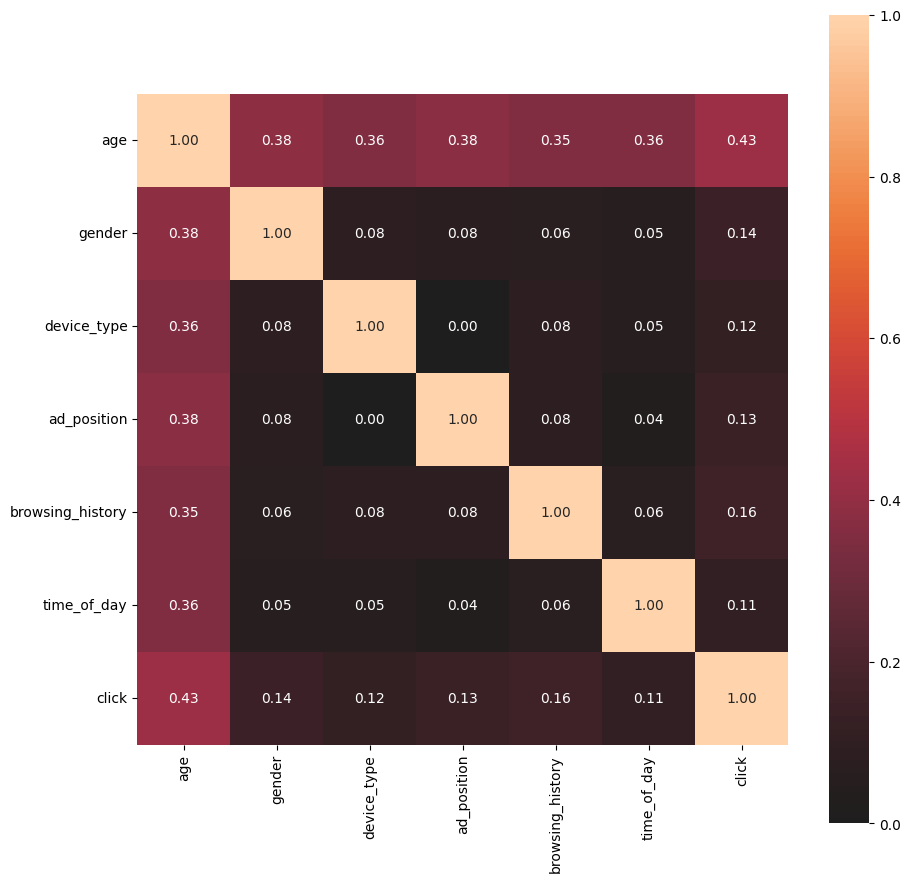

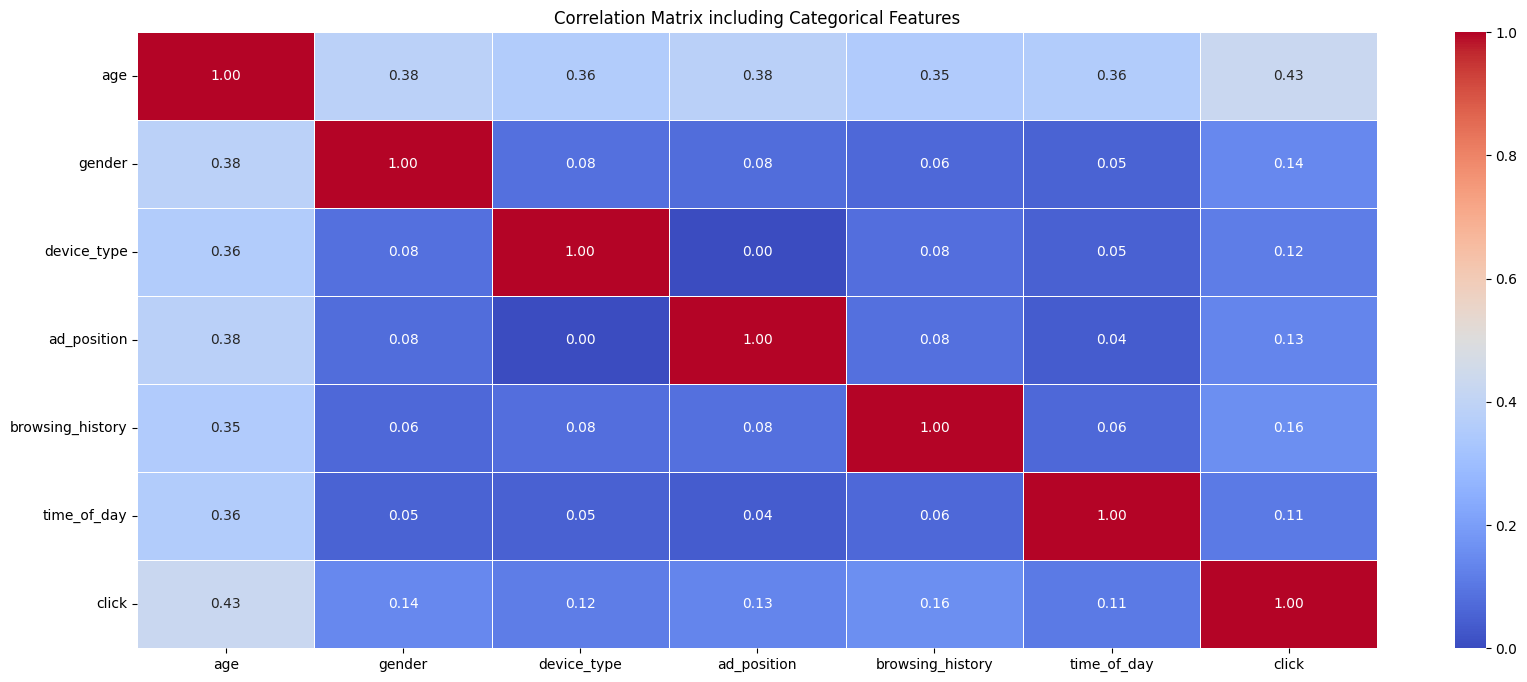

In [ ]:
associations_df = associations(df, nominal_columns='all', plot=False)

corr_matrix = associations_df['corr']

plt.figure(figsize=(20, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix including Categorical Features')
plt.show()

* **associations(df, nominal_columns='all', plot=False):** Verilen df veri çerçevesindeki sütunların tüm kombinasyonları arasındaki korelasyonları hesaplar ve bir çıktı döner.
  * nominal_columns='all': Veri çerçevesindeki tüm sütunlar kategorik olarak ele alınır.
  * plot=False: Korelasyon matrisi grafik olarak çizdirilmez; sadece veri döndürülür.
* associations_df adıyla bir çıktı döner. Bu çıktı, korelasyon değerlerini ve bazı ek bilgileri içerir.

**Tıklama (click) ile Diğer Değişkenler Arasındaki Korelasyonlar:** Bu matrisin asıl odak noktası, tıklama davranışı ile diğer faktörler arasındaki ilişkidir.

**Yaş (age) ve Tıklama (click):** 0.43 gibi orta düzeyde bir pozitif korelasyon var. Bu, yaş arttıkça tıklama olasılığının da biraz arttığını gösteriyor olabilir.

**Cinsiyet (gender) ve Tıklama (click):** 0.13 gibi düşük bir pozitif korelasyon var. Bu, cinsiyetin tıklama üzerinde çok az bir etkisi olduğunu gösteriyor.

**Cihaz Türü (device_type) ve Tıklama (click):** 0.37 gibi orta düzeyde bir pozitif korelasyon var. Bu, bazı cihaz türlerinin (örneğin, mobil) tıklama olasılığını etkileyebileceğini gösteriyor.

**Reklam Konumu (ad_position) ve Tıklama (click):** 0.38 gibi orta düzeyde bir pozitif korelasyon var. Bu, reklamın konumunun tıklama üzerinde önemli bir etkisi olduğunu gösteriyor (daha önce gördüğümüz gibi, alt konum genellikle daha etkili).

**Tarama Geçmişi (browsing_history) ve Tıklama (click)**: 0.11 gibi düşük bir pozitif korelasyon var. Tarama geçmişinin tıklama üzerinde çok az bir etkisi var gibi görünüyor.

**Günün Saati (time_of_day) ve Tıklama (click): **0.38 gibi orta düzeyde bir pozitif korelasyon var. Bu, günün farklı saatlerinde tıklama oranlarının değiştiğini gösteriyor (sabah ve öğleden sonra genellikle daha yüksek).

In [ ]:
X = df.drop('click', axis=1)
y = df['click']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
object_columns = df.select_dtypes(include='object').columns

preprocessor = ColumnTransformer(
    transformers=[(f'{col}_ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False), [col]) for col in object_columns],
    remainder='passthrough'
)

* Veri çerçevesindeki tüm kategorik sütunlar One-Hot Encoding işlemine tabi tutulur.

* Kategorik olmayan sütunlar (ör. sayısal sütunlar) olduğu gibi korunur.

* Bir preprocessor nesnesi oluşturulur. Bu nesne, daha sonra fit_transform() veya transform() metotları ile veri setine uygulanabilir.

In [ ]:
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

model = XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=94, use_label_encoder=False, eval_metric='logloss')

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('adasyn', ADASYN(random_state=94)),
    ('classifier', model)
])

Bu kod, dengesiz bir veri setinde azınlık sınıfını güçlendirmek için **XGBoost** modeli ile bir pipeline oluşturur. İlk adımda, kategorik değişkenler için **One-Hot Encoding** uygulanır ve sayısal sütunlar korunur. Daha sonra, azınlık sınıfındaki örnekleri artırmak amacıyla **ADASYN (Adaptive Synthetic Sampling)** kullanılarak sınıf dengesi sağlanır. XGBoost modeline, sınıflar arasındaki dengesizliği hesaba katması için scale_pos_weight parametresi ile azınlık ve çoğunluk sınıflarının oranı verilir. Pipeline, ön işleme, veri artırma ve modelleme adımlarını tek bir yapı altında toplar ve tüm süreci düzenli hale getirerek, dengesiz veri setlerinde güçlü bir model oluşturmayı hedefler.

**Pipeline, **veri işleme ve modelleme adımlarını tek bir yapı içinde organize eden bir araçtır.
* Farklı işlemleri (örneğin, veri ön işleme, özellik çıkarma, model eğitimi) bir araya getirerek, süreci daha düzenli ve tekrarlanabilir hale getirmektir.

**Bir pipeline, adımları sırayla uygular:**

* Veri ön işleme (ör. kategorik değişkenlerin kodlanması, eksik verilerin doldurulması).

* Özellik mühendisliği (ör. veri ölçeklendirme, normalizasyon).

* Model eğitimi (ör. bir makine öğrenimi modeli kullanarak tahmin yapma).

Örneğin, bir pipeline kullanarak hem veri setini temizleyebilir hem de modeli aynı yapıda eğitebiliriz. Pipeline'ın avantajı, her adımın doğru sırada ve otomatik olarak çalışmasını sağlamasıdır.

**ADASYN (Adaptive Synthetic Sampling),** dengesiz veri setlerinde azınlık sınıfını güçlendirmek için kullanılan bir veri artırma yöntemidir.

**Nasıl Çalışır?**

*Azınlık sınıfı örnekleri için sentetik (yeni) veri noktaları üretir.
* Sentetik noktalar, azınlık sınıfının çoğunluk sınıfına yakın olan karmaşık bölgelerinde yoğunlaşır.
* Bu, modelin daha zor öğrenilen sınırlarda daha iyi performans göstermesini sağlar.

In [ ]:
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

In [ ]:
print("Sınıflandırma Raporu:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Sınıflandırma Raporu:
               precision    recall  f1-score   support

         0.0       0.96      0.86      0.91       705
         1.0       0.93      0.98      0.95      1295

    accuracy                           0.94      2000
   macro avg       0.94      0.92      0.93      2000
weighted avg       0.94      0.94      0.94      2000

Confusion Matrix:
 [[ 607   98]
 [  28 1267]]


In [ ]:
def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title("Confusion Matrix")
    plt.ylabel("Gerçek Label")
    plt.xlabel("Tahmin Edilen Label")
    plt.show()

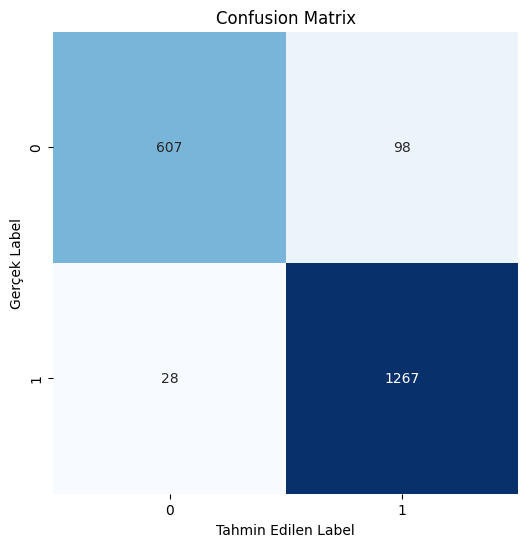

In [ ]:
plot_confusion_matrix(y_test, y_pred)

In [ ]:

param_grid = {
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5, 7]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("En iyi Parametreler: ", grid_search.best_params_)

GridSearchCV ile XGBoost modeli için en iyi hiperparametreleri seçmeyi amaçladık.
* Pipeline üzerinde tanımlı hiperparametrelerin her kombinasyonunu çapraz doğrulama (cross-validation) kullanarak test ediyoruz.

* cv=5: 5 katlı çapraz doğrulama yapılır (veri 5 parçaya bölünerek her bir parça doğrulama için kullanılır).

* scoring='accuracy': Modelin doğruluk metriğine göre en iyi parametreleri belirler.

En iyi Parametreler: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 7, 'classifier__n_estimators': 200}

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning:

[00:52:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




Sınıflandırma Raporu (Best Model):
               precision    recall  f1-score   support

         0.0       1.00      0.89      0.94       705
         1.0       0.94      1.00      0.97      1295

    accuracy                           0.96      2000
   macro avg       0.97      0.94      0.95      2000
weighted avg       0.96      0.96      0.96      2000

Confusion Matrix (Best Model):
 [[ 625   80]
 [   2 1293]]


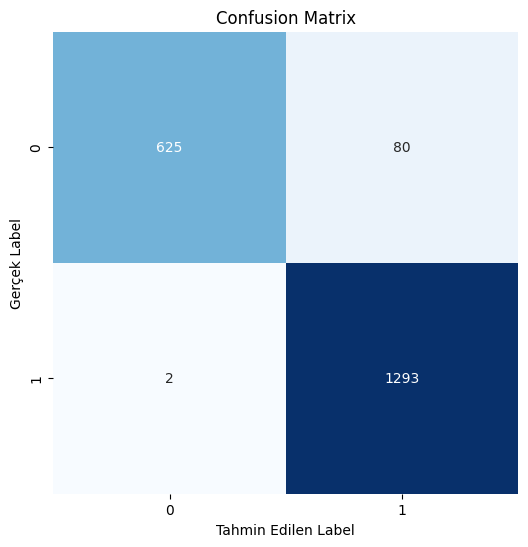

In [ ]:
model_best = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    learning_rate=0.2,
    max_depth=7,
    n_estimators=200,
    random_state=94,
    use_label_encoder=False,
    eval_metric='logloss'
)

pipeline_best = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('adasyn', ADASYN(random_state=94)),
    ('classifier', model_best)
])

pipeline_best.fit(X_train, y_train)

y_pred_best = pipeline_best.predict(X_test)

print("Sınıflandırma Raporu (Best Model):\n", classification_report(y_test, y_pred_best))
print("Confusion Matrix (Best Model):\n", confusion_matrix(y_test, y_pred_best))

plot_confusion_matrix(y_test, y_pred_best)

**Precision:**
* 0.0 sınıfı için: %100, yani model "0" sınıfını tahmin ederken hiçbir hata yapmamış.
* 1.0 sınıfı için: %95, yani modelin "1" sınıfını tahmin ederken yanılma oranı %5.

**Recall:**
* 0.0 sınıfı için: %90, yani model "0" sınıfındaki gerçek örneklerin %90'ını doğru tahmin etmiş.
* 1.0 sınıfı için: %100, yani "1" sınıfındaki tüm gerçek örnekleri doğru tahmin etmiş.

**F1-Score:**
* Precision ve recall'un harmonik ortalamasıdır. Modelin dengeli bir şekilde doğru tahmin yapma kapasitesini gösterir.
* 0.0 sınıfı için: 0.95
* 1.0 sınıfı için: 0.97

**Genel olarak:** F1-Score oldukça yüksek (ortalama 0.96), bu da modelin her iki sınıfta da iyi bir performans sergilediğini gösteriyor.

**Accuracy:**
Genel doğruluk %96, yani model tüm verilerde %96 doğruluk oranı ile sınıflandırma yapmış.
